In [1]:
import glob
import random
import os
import math
import itertools
import sys

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image
import argparse# Importing Libraries

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pickle
from torchvision.models import vgg19

In [2]:
from ECV_Generator import *
from util import *

In [3]:
import torch

# Load the model with 'map_location' argument
model = color_ecv()
model.load_state_dict(torch.load("pretrained_models/generator.pth", map_location=torch.device('cpu')))
model.eval()


color_ecv(
  (model): ECCVGenerator(
    (model1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (model2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (model3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3

In [4]:
class TestDataset(Dataset):
    def __init__(self, root, single_image):
        if single_image:
            self.files = [root]
        else:
            self.files = sorted(glob.glob(root + "/*.*"))
        
    def __getitem__(self, index):
       
        black_path = self.files[index % len(self.files)]
        img_black = np.asarray(Image.open(black_path))
        if(img_black.ndim==2):
            img_black = np.tile(img_black[:,:,None],3)
        (tens_l_orig, tens_l_rs) = preprocess_img(img_black, HW=(400, 400))

        return {"black": tens_l_rs.squeeze(0), 'orig': tens_l_orig.squeeze(0), 'path' : black_path}
    
    def __len__(self):
        return len(self.files)

In [5]:
def predict_outputs(model, dataset):
    #image = single_image
    batch_size = 1
    dataloader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 0,
    )

    cuda = torch.cuda.is_available()
    if cuda:
        model = model.to('cuda')

    Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
    outputs = {}
    for i, imgs in enumerate(dataloader):
        imgs_black = Variable(imgs["black"].type(Tensor))
        imgs_black_orig = Variable(imgs["orig"].type(Tensor))
        gen_ab = model(imgs_black)
        gen_ab.detach_
        gen_color = postprocess_tens_new(imgs_black_orig, gen_ab)[0].transpose(1,2,0)
        outputs[imgs["path"][0]] = gen_color
    return outputs

In [6]:
def print_images(outputs):
    for i in outputs.keys():
        print("----------- The Black and White Image -----------")
        plt.imshow(plt.imread(i))
        plt.show()
        print("----------- The Colourfull Image Generated -----------")
        plt.imshow(outputs[i])
        plt.show()

In [7]:
def save_outputs(outputs, folder_path, single_image):
    os.makedirs(folder_path,  exist_ok=True)
    for i in outputs.keys():
        if single_image:
            name = i.split('/')[-1]
        else:
            name = i.split('\\')[-1]
        image = Image.fromarray((outputs[i] * 255).astype(np.uint8)) 
        image.save(folder_path + '/' + name)

c:\Users\SUYOG\Desktop\Image Colourized\Image Colorized\util.py:69: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8758 negative Z values that have been clipped to zero
  output_.append(color.lab2rgb(out_lab_orig_i.data.cpu().numpy()[0,...].transpose((1,2,0))).transpose((2,0,1)))


----------- The Black and White Image -----------


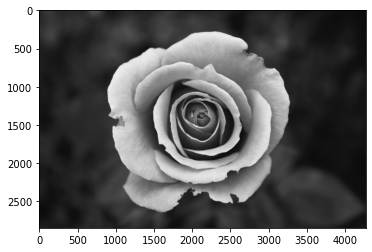

----------- The Colourfull Image Generated -----------


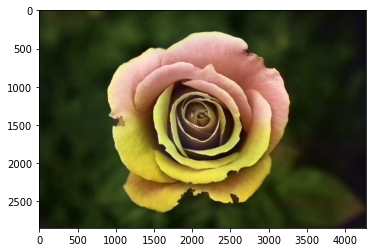

In [11]:
single_image = True
path = 'sample/100.jpg'
dataset = TestDataset(path, single_image)
outputs = predict_outputs(model, dataset)

print_images(outputs)

save_outputs(outputs, folder_path = 'Outputs/single_Outputs', single_image = single_image)

In [9]:
single_image = False
path = 'sample'
dataset = TestDataset(path, single_image)
outputs = predict_outputs(model, dataset)

print_images(outputs)

save_outputs(outputs, folder_path = 'Outputs/multiple_Outputs', single_image = single_image)

In [10]:
pickle.dump(model, open('model.pkl', 'wb'))
model = pickle.load(open('model.pkl','rb'))